<a href="https://colab.research.google.com/github/StratosFair/DNN_Classifiers_Fast_Rates/blob/main/cifar10_auto_truck_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# CIFAR-10 Classes
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define transforms to convert images into tensors
cifar_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=cifar_transform)
cifar_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=cifar_transform)

# Filter for automobile (class 1) and truck (class 9)
indices_auto = [i for i, (_, label) in enumerate(cifar_train) if label == 1] #formerly cat
indices_truck = [i for i, (_, label) in enumerate(cifar_train) if label == 9] #formerly dog

# Combine indices
train_indices = indices_auto + indices_truck
test_indices = [i for i, (_, label) in enumerate(cifar_test) if label in [1, 9]]

# Create train and test subsets
train_data = Subset(cifar_train, train_indices)
test_data = Subset(cifar_test, test_indices)

# Assign labels: Truck -> +1, Automobile -> -1
def assign_labels(subset):
    images, labels = zip(*[(data[0], 1.0 if data[1] == 9 else -1.0) for data in subset])
    return torch.stack(images), torch.tensor(labels)

# Assign labels to train and test datasets
X_train, y_train = assign_labels(train_data)
X_test, y_test = assign_labels(test_data)

# Verify data shapes
print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


Train data shape: torch.Size([10000, 3, 32, 32]), Train labels shape: torch.Size([10000])
Test data shape: torch.Size([2000, 3, 32, 32]), Test labels shape: torch.Size([2000])


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.network = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Fully connected layers
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Outputs a scalar value (-1 to 1)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = SimpleCNN()
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the loss threshold
loss_threshold = 0.005

# Training loop with early stopping
epochs = 500
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # Forward pass
        outputs = model(images).squeeze()  # Output shape: [batch_size]
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)

    # Print progress
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Check if loss is below the threshold
    if avg_loss < loss_threshold:
        print(f"Stopping early at epoch {epoch+1} as loss fell below {loss_threshold:.4f}")
        break

In [9]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = []
    for images, _ in test_loader:
        outputs = model(images).squeeze()  # Predicted values (-1 to 1)
        y_pred.extend(outputs.tolist())

# Convert predictions to numpy array for histogram
y_pred = np.array(y_pred)

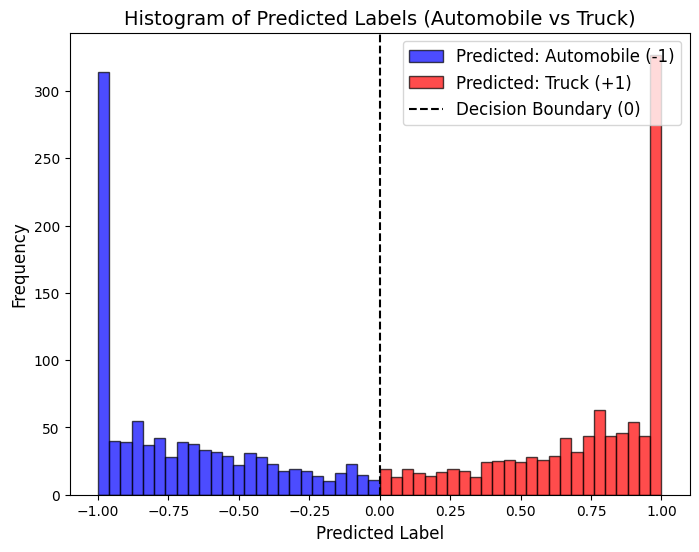

In [10]:
# Clip predictions to [-1, 1]
y_pred = np.clip(y_pred, -1, 1)

# Plot histogram
plt.figure(figsize=(8, 6))
bins = np.linspace(-1, 1, 51)  # 50 bins between -1 and 1
plt.hist(y_pred[y_pred < 0], bins=bins, alpha=0.7, color='blue', edgecolor='black', label='Predicted: Automobile (-1)')
plt.hist(y_pred[y_pred > 0], bins=bins, alpha=0.7, color='red', edgecolor='black', label='Predicted: Truck (+1)')
plt.axvline(0, color='black', linestyle='--', label='Decision Boundary (0)')

# Add labels and title
plt.title("Histogram of Predicted Labels (Automobile vs Truck)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=12)
plt.show()